---
title: Dask 101
subtitle: D.03.10 HANDS-ON TRAINING - EarthCODE 101 Hands-On Workshop - Example showing how to access data on the EarthCODE Open Science Catalog and working with the Pangeo ecosystem on EDC
authors:
  - name: Deyan Samardzhiev
    github: sunnydean
    orcid: 0009-0003-3803-8522
    affiliations:
      - id: Lampata UK
        institution: Lampata UK
reviewers:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
date: 2025-06-01
thumbnail: https://raw.githubusercontent.com/ESA-EarthCODE/documentation/refs/heads/main/pages/public/img/EarthCODE_kv_transparent.png
keywords: ["earthcode", "pangeo", "stac", "xarray", "earth observation", "remote sensing"]
tags: ["pangeo"]
releaseDate: 2025-06-01
datePublished: 2025-06-01
dateModified: 2025-06-01
banner: ../static/PANGEO.png
github: https://github.com/sunnydean/LPS25_Pangeo_x_EarthCODE_Workshop
license: MIT
---

# Context
We will be using Dask with Xarray to parallelize our data analysis. The analysis is very similar to what we have done in previous examples but this time we will use data on a global coverage that we read from the SeasFire Cube.


### Data

In this workshop, we will be using the [SeasFire Data Cube](https://opensciencedata.esa.int/products/seasfire-cube/collection) published to the EarthCODE Open Science Catalog

#### Related publications
* *Alonso, Lazaro, Gans, Fabian, Karasante, Ilektra, Ahuja, Akanksha, Prapas, Ioannis, Kondylatos, Spyros, Papoutsis, Ioannis, Panagiotou, Eleannna, Michail, Dimitrios, Cremer, Felix, Weber, Ulrich, & Carvalhais, Nuno. (2022). SeasFire Cube: A Global Dataset for Seasonal Fire Modeling in the Earth System (0.4) [Data set]. Zenodo. @alonso-2024. The same dataset can also be downloaded from Zenodo: https://zenodo.org/records/13834057*


In [1]:
import xarray

## Parallelize with Dask

We know from previous chapter [cloud native formats 101](./cloud-native-formats101.ipynb) that chunking is key for analyzing large datasets. In this episode, we will learn to parallelize our data analysis using [Dask](https://docs.dask.org/) on our chunked dataset. 

### What is [Dask](https://docs.dask.org/) ?

**Dask** scales the existing Python ecosystem: with very or no changes in your code, you can speed-up computation using Dask or process bigger than memory datasets.

- Dask is a flexible library for parallel computing in Python.
- It is widely used for handling large and complex Earth Science datasets and speed up science.
- Dask is powerful, scalable and flexible. It is the leading platform today for data analytics at scale.
- It scales natively to clusters, cloud, HPC and bridges prototyping up to production.
- The strength of Dask is that is scales and accelerates the existing Python ecosystem e.g. Numpy, Pandas and Scikit-learn with few effort from end-users.

It is interesting to note that at first, [Dask has been created to handle data that is larger than memory, on a single computer](https://coiled.io/blog/history-dask/). It then was extended with Distributed to compute data in parallel over clusters of computers.

#### How does Dask scale and accelerate your data analysis?

[Dask proposes different abstractions to distribute your computation](https://docs.dask.org/en/stable/10-minutes-to-dask.html). In this _Dask Introduction_ section, we will focus on [Dask Array](https://docs.dask.org/en/stable/array.html) which is widely used in pangeo ecosystem as a back end of Xarray.

As shown in the [previous section](./chunking_introduction.ipynb) Dask Array is based on chunks.
Chunks of a Dask Array are well-known Numpy arrays. By transforming our big datasets to Dask Array, making use of chunk, a large array is handled as many smaller Numpy ones and we can compute each of these chunks independently.

![Dask and Numpy](https://examples.dask.org/_images/dask-array-black-text.svg)



#### How does Xarray with Dask distribute data analysis?

When we use chunks with `Xarray`, the real computation is only done when needed or asked for, usually when invoking `compute()` or `load()` functions. Dask generates a **task graph** describing the computations to be done. When using [Dask Distributed](https://distributed.dask.org/en/stable/) a **Scheduler** distributes these tasks across several **Workers**.

![Xarray with da sk](../static/dask-xarray-explained.png)

### What is a Dask Distributed cluster ?

A Dask Distributed cluster is made of two main components:

- a Scheduler, responsible for handling computations graph and distributing tasks to Workers.
- One or several (up to 1000s) Workers, computing individual tasks and storing results and data into distributed memory (RAM and/or worker's local disk).

A user usually needs __Client__ and __Cluster__ objects as shown below to use Dask Distributed.    

![Dask Distributed Cluster](https://user-images.githubusercontent.com/306380/66413985-27111600-e9be-11e9-9995-8f418ff48f8a.png)

:::{tip}
A Dask `Cluster` can be created on a single machine (for instance your laptop) e.g. there is no need to have dedicated computational resources. However, speedup will only be limited to your single machine resources if you do not have dedicated computational resources!
:::

### Dask distributed Client
 
The Dask distributed `Client` is what allows you to interact with Dask distributed Clusters. When using Dask distributed, you always need to create a `Client` object. Once a `Client` has been created, it will be used by default by each call to a Dask API, even if you do not explicitly use it.

No matter the Dask API (e.g. Arrays, Dataframes, Delayed, Futures, etc.) that you use, under the hood, Dask will create a Directed Acyclic Graph (DAG) of tasks by analysing the code. Client will be responsible to submit this DAG to the Scheduler along with the final result you want to compute. The Client will also gather results from the Workers, and aggregate it back in its underlying Python process.

Using `Client()` function with no argument, you will create a local Dask cluster with a number of workers and threads per worker corresponding to the number of cores in the 'local' machine. Here, during the workshop, we are running this notebook in the EDC Pangeo cloud deployment, so the 'local' machine is the jupyterlab you are using at the Cloud, and the number of cores is the number of cores on the cloud computing resources you've been given (not on your laptop).

In [2]:
from dask.distributed import Client

client = Client()   # create a local dask cluster on the local machine.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38627,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.46 GiB
Comm: tcp://127.0.0.1:36437,Total threads: 4
Dashboard: http://127.0.0.1:39395/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:43747,


Inspecting the `Cluster Info` section above gives us information about the created cluster: we have 2 or 4 workers and the same number of threads (e.g. 1 thread per worker). 


## Dask Parallel computations on our dataset

Let's open the SeasFire dataset we previously looked at, select a single location over time, visualize the task graph generated by Dask, and observe the Dask Dashboard.

In [3]:
http_url = "https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr/"

ds = xarray.open_dataset(
	http_url,
	engine='zarr',
    chunks={},
	consolidated=True
)
ds

<xarray.Dataset> Size: 164GB
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
Data variables: (12/59)
    area                            (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    biomes                          (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    cams_co2fire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    cams_frpfire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_max                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_mean               (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_mean                        (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_min                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd                             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

In [4]:
mask= ds['lsm'][:,:]
gwis_all= ds.gwis_ba.resample(time="1YE").sum()
gwis_all= gwis_all.where(mask>0.5)

gwis_2020= gwis_all.sel(time='2020-08-01', method='nearest')
gwis_2020.data

dask.array<getitem, shape=(720, 1440), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>

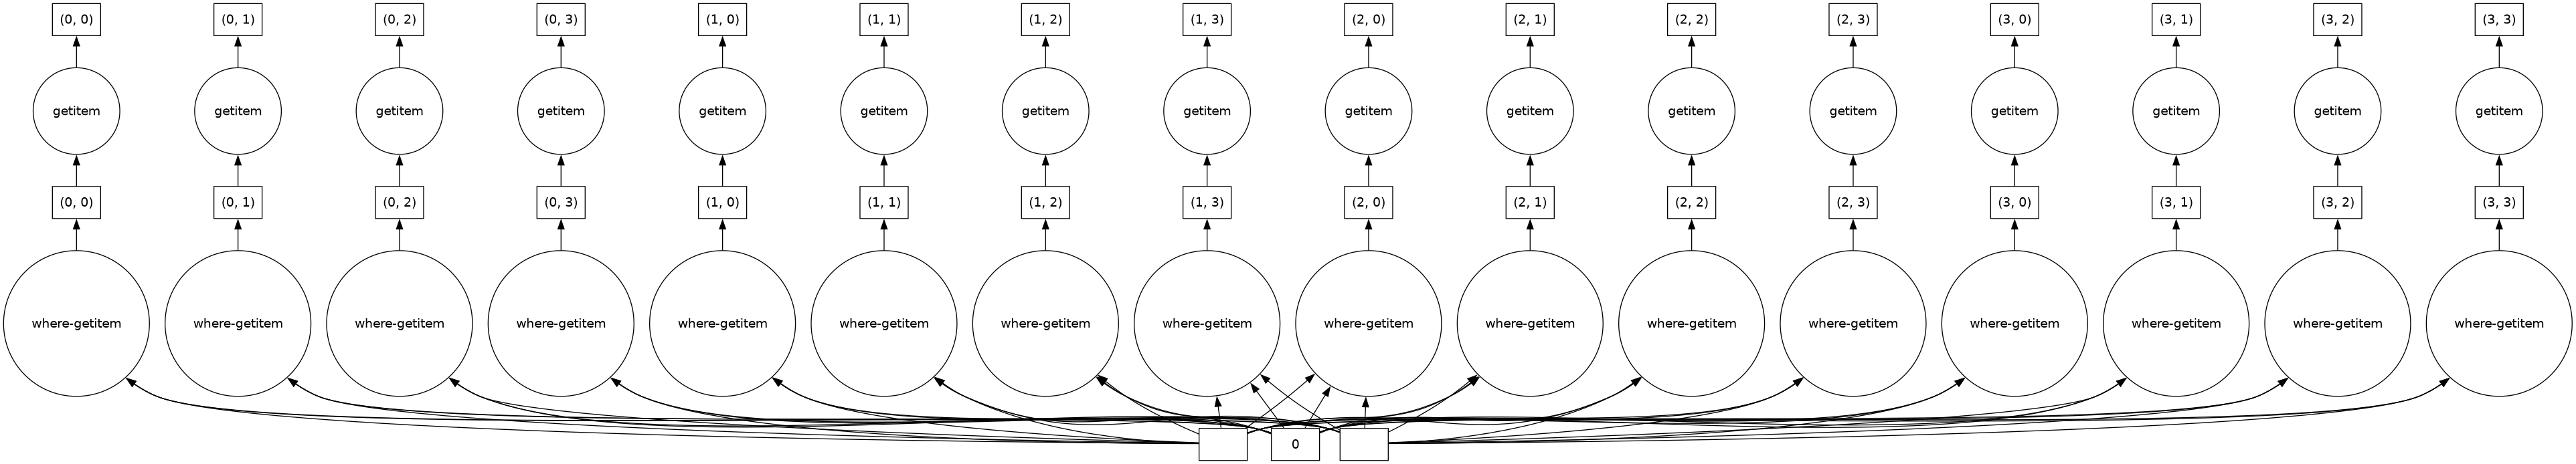

In [5]:
gwis_2020.data.visualize(optimize_graph=True)


We didn't 'compute' anything. We just built a Dask task graph with it's size indicated as count above, but did not ask Dask to return a result.

Note that underneath, dask optimizes the execution graph (opaquely), so as to minimize overheads and overall execution resources (hence why we're passing optimize_graph=True)

# Computing

Calling compute on our Xarray object will trigger the execution on the Dask Cluster. Alternatively any action that would demand the computation of our data (e.g. plotting) would trigger the execution of our workflow.

You should be able to see how Dask is working on Dask Dashboard. 

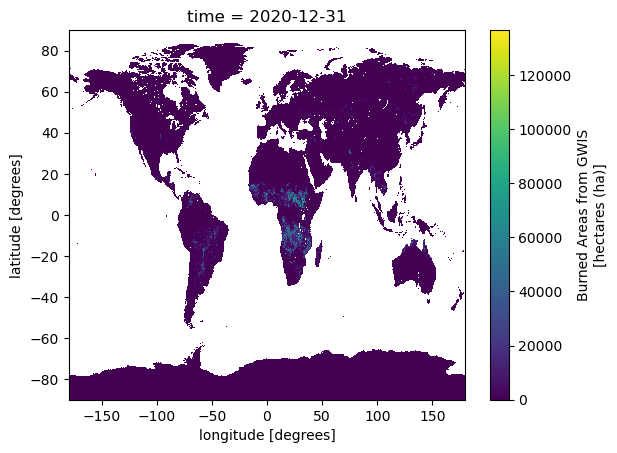

In [6]:
gwis_2020.plot()

# Closing Clusters
Close Clusters to Clean Resources for the next exercise (generally a good practice!)

In [7]:
# close client to clean resources
client.close()